In [3]:
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import xml.etree.ElementTree as ET

In [28]:
file_path = "data/raw/train/559-ws-training.xml"
tree = ET.parse(file_path)
root = tree.getroot()

In [43]:
# Extract data
glucose_section = root.find("glucose_level")
data = []
for entry in glucose_section:
    timestamp = entry.attrib["ts"]
    value = float(entry.attrib["value"])
    data.append([timestamp, value])

# Create DataFrame
df = pd.DataFrame(data, columns=["timestamp", "glucose"])

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(
    df["timestamp"],
    format="%d-%m-%Y %H:%M:%S"
)

# Sort by time
df = df.sort_values("timestamp")

# Show info
print("\n===== HEAD =====")
print(df.head())

print("\n===== INFO =====")
print(df.info())

print("\n===== DESCRIBE =====")
print(df.describe())


===== HEAD =====
            timestamp  glucose
0 2021-12-07 01:17:00    101.0
1 2021-12-07 01:22:00     98.0
2 2021-12-07 01:27:00    104.0
3 2021-12-07 01:32:00    112.0
4 2021-12-07 01:37:00    120.0

===== INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10796 entries, 0 to 10795
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10796 non-null  datetime64[ns]
 1   glucose    10796 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 168.8 KB
None

===== DESCRIBE =====
                           timestamp       glucose
count                          10796  10796.000000
mean   2021-12-28 04:05:26.771026176    166.692293
min              2021-12-07 01:17:00     40.000000
25%              2021-12-17 15:41:45    108.000000
50%              2021-12-28 13:12:30    157.000000
75%              2022-01-07 12:52:15    212.000000
max              2022-01-17 23:56:00 

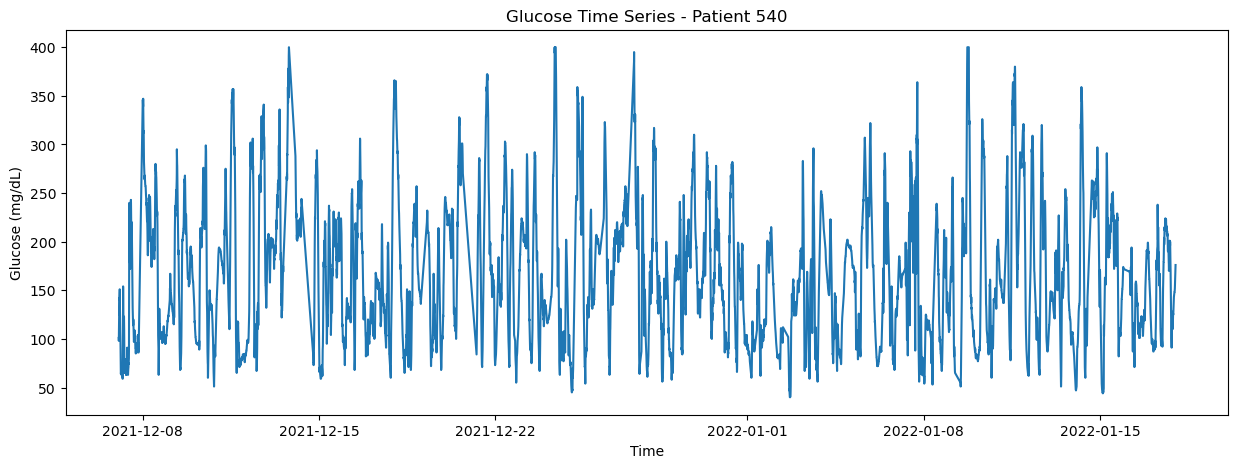

In [21]:
plt.figure(figsize=(15,5))
plt.plot(df["timestamp"], df["glucose"])
plt.title("Glucose Time Series - Patient 540")
plt.xlabel("Time")
plt.ylabel("Glucose (mg/dL)")
plt.show()

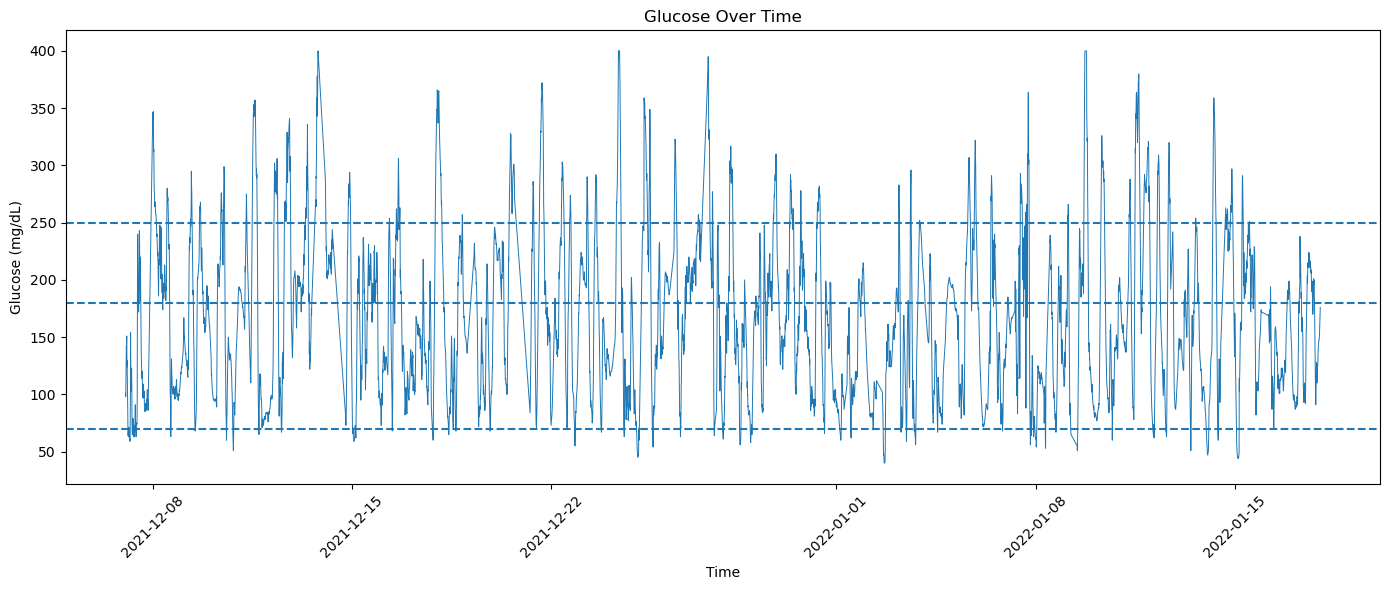

In [23]:
# Make sure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort chronologically
df = df.sort_values('timestamp')

# Create plot
plt.figure(figsize=(14,6))

plt.plot(df['timestamp'], df['glucose'], linewidth=0.7)

# Add reference lines
plt.axhline(70, linestyle='--')    # Low threshold
plt.axhline(180, linestyle='--')   # High threshold
plt.axhline(250, linestyle='--')   # Severe high

plt.title("Glucose Over Time")
plt.xlabel("Time")
plt.ylabel("Glucose (mg/dL)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


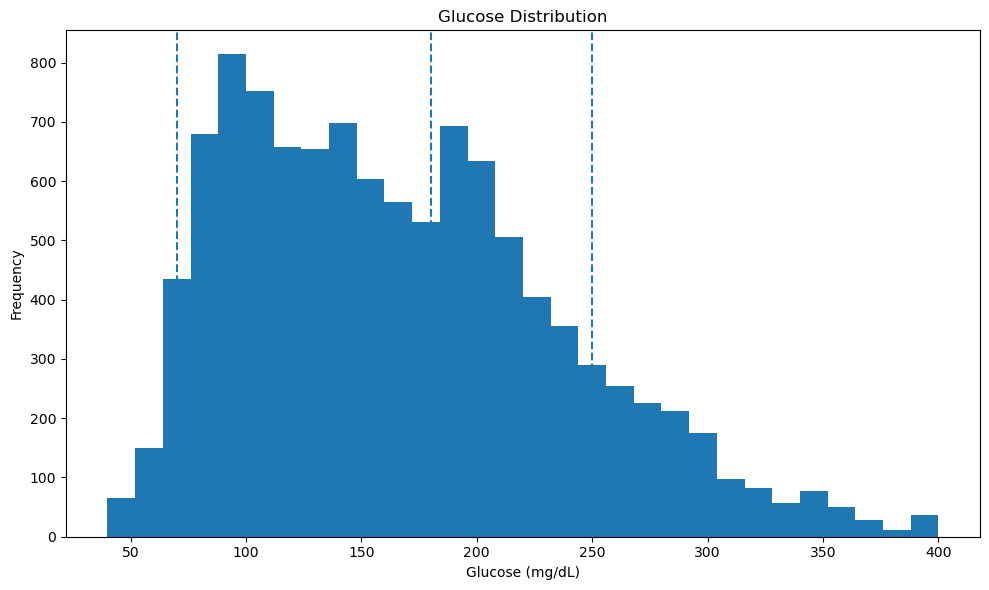

In [24]:
plt.figure(figsize=(10,6))

plt.hist(df['glucose'], bins=30)

# Reference lines
plt.axvline(70, linestyle='--')
plt.axvline(180, linestyle='--')
plt.axvline(250, linestyle='--')

plt.title("Glucose Distribution")
plt.xlabel("Glucose (mg/dL)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


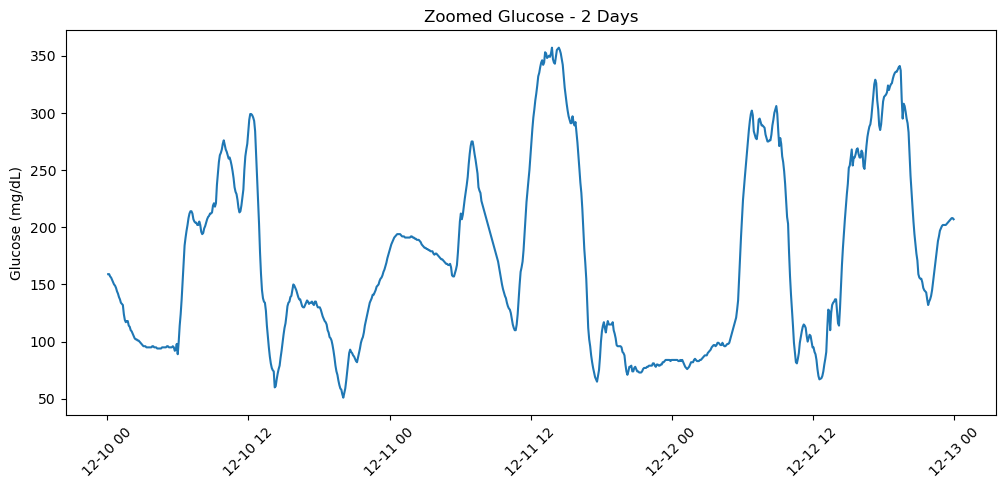

In [31]:
# Set timestamp as index (if not already)
df = df.set_index("timestamp")

# Select 2 days only
zoom_df = df.loc["2021-12-10":"2021-12-12"]

plt.figure(figsize=(12,5))
plt.plot(zoom_df.index, zoom_df["glucose"])
plt.title("Zoomed Glucose - 2 Days")
plt.ylabel("Glucose (mg/dL)")
plt.xticks(rotation=45)
plt.show()

# There are, as we can see, weird spikes, even in a short time frame

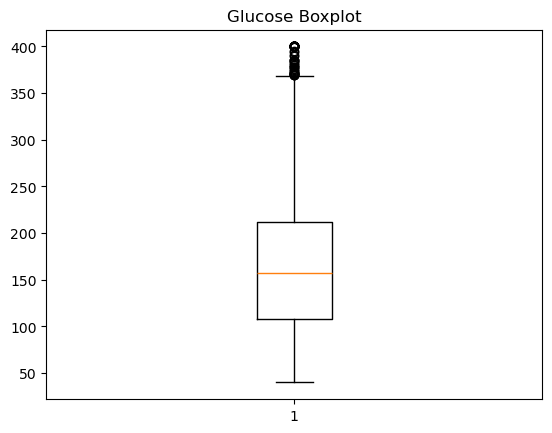

In [33]:
plt.boxplot(df["glucose"])
plt.title("Glucose Boxplot")
plt.show()
# physiologically these are not outliers
# Glucose is naturally skewed and can:
# Spike after meals
# Reach 350–400 mg/dL in hyperglycemia
# Drop to 40–50 mg/dL in hypoglycemia
# Those are clinically meaningful events, not noise.

In [39]:
df["diff"] = df.index.to_series().diff()
print(df["diff"].value_counts().head())
## sometimes the sensor failed to give the results every 5 mins

diff
0 days 00:05:00    10752
0 days 01:25:00        4
0 days 01:30:00        3
0 days 01:05:00        2
0 days 00:35:00        2
Name: count, dtype: int64


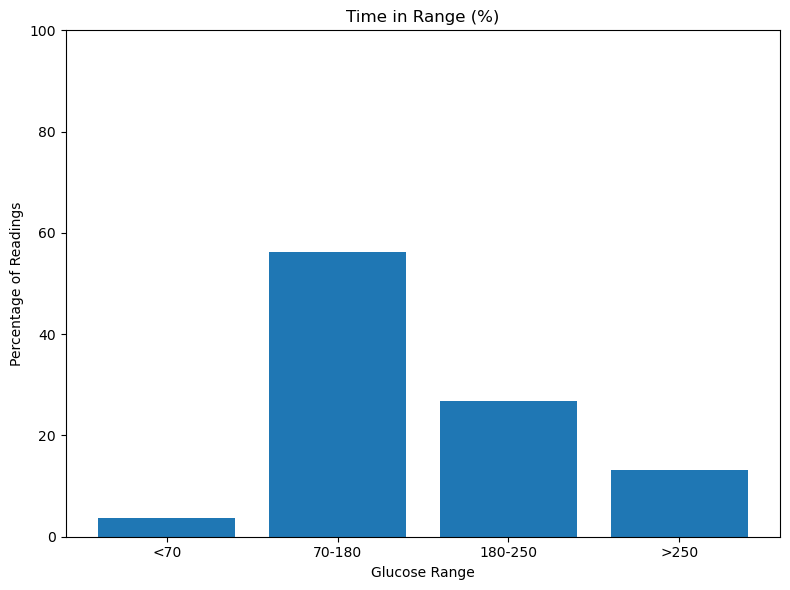

<70: 3.79%
70-180: 56.23%
180-250: 26.87%
>250: 13.11%


In [44]:
# Total number of readings
total = len(df)

# Calculate counts
below_70 = (df['glucose'] < 70).sum()
in_range = ((df['glucose'] >= 70) & (df['glucose'] <= 180)).sum()
high = ((df['glucose'] > 180) & (df['glucose'] <= 250)).sum()
very_high = (df['glucose'] > 250).sum()

# Convert to percentages
tir_data = [
    below_70 / total * 100,
    in_range / total * 100,
    high / total * 100,
    very_high / total * 100
]

labels = ["<70", "70-180", "180-250", ">250"]

# Plot
plt.figure(figsize=(8,6))
plt.bar(labels, tir_data)

plt.title("Time in Range (%)")
plt.ylabel("Percentage of Readings")
plt.xlabel("Glucose Range")

plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Print numeric values too
for label, value in zip(labels, tir_data):
    print(f"{label}: {value:.2f}%")


In [47]:
duplicates = df.index.duplicated().sum()
print("Duplicate timestamps:", duplicates)

Duplicate timestamps: 0


In [49]:
df["delta"] = df["glucose"].diff()

print("Max increase in 5 min:", df["delta"].max())
print("Max decrease in 5 min:", df["delta"].min())

Max increase in 5 min: 257.0
Max decrease in 5 min: -186.0


In [53]:
# Small gaps → interpolate

# Large gaps → keep NaN

In [56]:
df = df.sort_index()

df_resampled = df.resample("5min").mean()

In [58]:
print("Missing before interpolation:",
      df_resampled["glucose"].isna().sum())

Missing before interpolation: 1285


In [62]:
df_resampled["glucose"] = df_resampled["glucose"].interpolate(
    method="linear",
    limit=2
)

In [64]:
print("Missing after interpolation:",
      df_resampled["glucose"].isna().sum())

Missing after interpolation: 980


In [65]:
time_diff = df_resampled.index.to_series().diff()
glucose_diff = df_resampled["glucose"].diff()

valid_changes = glucose_diff[time_diff == pd.Timedelta(minutes=5)]

print("Max 5-min increase:", valid_changes.max())
print("Max 5-min decrease:", valid_changes.min())

Max 5-min increase: 110.0
Max 5-min decrease: -71.0


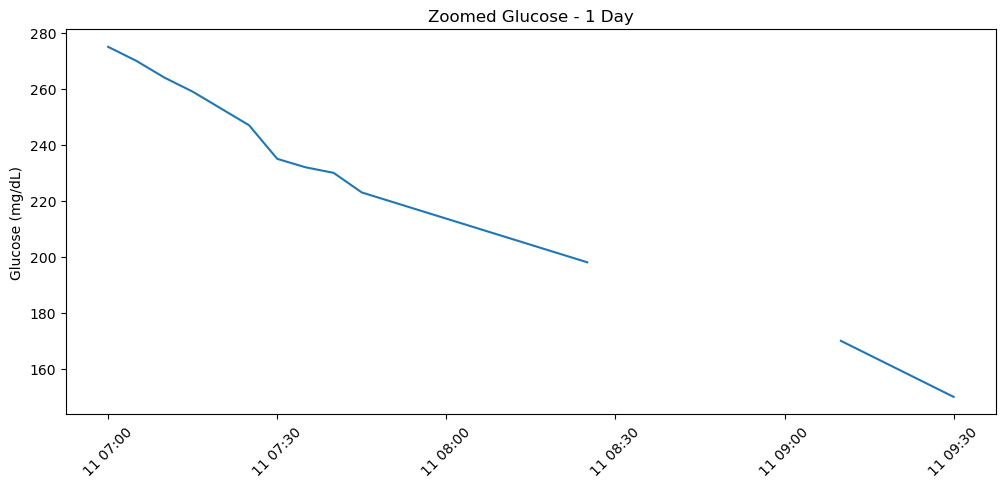

In [79]:
# Set timestamp as index (if not already)

# Select 2 days only and specific time
zoom_df = df_resampled.loc["2021-12-11 07:00:00":"2021-12-11 09:30:00"]

plt.figure(figsize=(12,5))
plt.plot(zoom_df.index, zoom_df["glucose"])
plt.title("Zoomed Glucose - 1 Day")
plt.ylabel("Glucose (mg/dL)")
plt.xticks(rotation=45)
plt.show()

# There are, as we can see, weird spikes, even in a short time frame

In [80]:
print(zoom_df.iloc[:50])

                        glucose  delta
timestamp                             
2021-12-11 07:00:00  275.000000    0.0
2021-12-11 07:05:00  270.000000   -5.0
2021-12-11 07:10:00  264.000000   -6.0
2021-12-11 07:15:00  259.000000   -5.0
2021-12-11 07:20:00  253.000000   -6.0
2021-12-11 07:25:00  247.000000   -6.0
2021-12-11 07:30:00  235.000000  -12.0
2021-12-11 07:35:00  232.000000   -3.0
2021-12-11 07:40:00  230.000000   -2.0
2021-12-11 07:45:00  223.000000   -7.0
2021-12-11 07:50:00  219.882353    NaN
2021-12-11 07:55:00  216.764706    NaN
2021-12-11 08:00:00  213.647059    NaN
2021-12-11 08:05:00  210.529412    NaN
2021-12-11 08:10:00  207.411765    NaN
2021-12-11 08:15:00  204.294118    NaN
2021-12-11 08:20:00  201.176471    NaN
2021-12-11 08:25:00  198.058824    NaN
2021-12-11 08:30:00         NaN    NaN
2021-12-11 08:35:00         NaN    NaN
2021-12-11 08:40:00         NaN    NaN
2021-12-11 08:45:00         NaN    NaN
2021-12-11 08:50:00         NaN    NaN
2021-12-11 08:55:00      

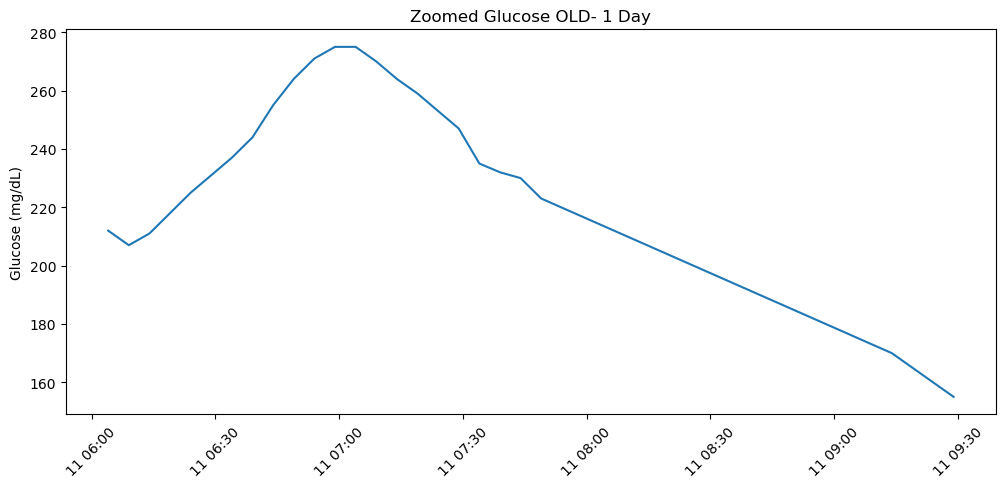

In [77]:
zoom_old_df = df.loc["2021-12-11 06:00:00":"2021-12-11 09:30:00"]

plt.figure(figsize=(12,5))
plt.plot(zoom_old_df.index, zoom_old_df["glucose"])
plt.title("Zoomed Glucose OLD- 1 Day")
plt.ylabel("Glucose (mg/dL)")
plt.xticks(rotation=45)
plt.show()

In [78]:
print(zoom_old_df.iloc[:50])

                     glucose  delta
timestamp                          
2021-12-11 06:04:00    212.0    7.0
2021-12-11 06:09:00    207.0   -5.0
2021-12-11 06:14:00    211.0    4.0
2021-12-11 06:19:00    218.0    7.0
2021-12-11 06:24:00    225.0    7.0
2021-12-11 06:29:00    231.0    6.0
2021-12-11 06:34:00    237.0    6.0
2021-12-11 06:39:00    244.0    7.0
2021-12-11 06:44:00    255.0   11.0
2021-12-11 06:49:00    264.0    9.0
2021-12-11 06:54:00    271.0    7.0
2021-12-11 06:59:00    275.0    4.0
2021-12-11 07:04:00    275.0    0.0
2021-12-11 07:09:00    270.0   -5.0
2021-12-11 07:14:00    264.0   -6.0
2021-12-11 07:19:00    259.0   -5.0
2021-12-11 07:24:00    253.0   -6.0
2021-12-11 07:29:00    247.0   -6.0
2021-12-11 07:34:00    235.0  -12.0
2021-12-11 07:39:00    232.0   -3.0
2021-12-11 07:44:00    230.0   -2.0
2021-12-11 07:49:00    223.0   -7.0
2021-12-11 09:14:00    170.0  -53.0
2021-12-11 09:19:00    165.0   -5.0
2021-12-11 09:24:00    160.0   -5.0
2021-12-11 09:29:00    155.0

In [89]:
df_resampled = df.resample("5min").mean()
zoom_df = df_resampled.loc["2021-12-11 07:00:00":"2021-12-11 09:30:00"]
print(zoom_df.iloc[:50])

df_resampled["glucose"] = df_resampled["glucose"].interpolate(
    method="linear",
    limit=2
)
zoom_df = df_resampled.loc["2021-12-11 07:00:00":"2021-12-11 09:30:00"]
print(zoom_df.iloc[:50])

                     glucose  delta
timestamp                          
2021-12-11 07:00:00    275.0    0.0
2021-12-11 07:05:00    270.0   -5.0
2021-12-11 07:10:00    264.0   -6.0
2021-12-11 07:15:00    259.0   -5.0
2021-12-11 07:20:00    253.0   -6.0
2021-12-11 07:25:00    247.0   -6.0
2021-12-11 07:30:00    235.0  -12.0
2021-12-11 07:35:00    232.0   -3.0
2021-12-11 07:40:00    230.0   -2.0
2021-12-11 07:45:00    223.0   -7.0
2021-12-11 07:50:00      NaN    NaN
2021-12-11 07:55:00      NaN    NaN
2021-12-11 08:00:00      NaN    NaN
2021-12-11 08:05:00      NaN    NaN
2021-12-11 08:10:00      NaN    NaN
2021-12-11 08:15:00      NaN    NaN
2021-12-11 08:20:00      NaN    NaN
2021-12-11 08:25:00      NaN    NaN
2021-12-11 08:30:00      NaN    NaN
2021-12-11 08:35:00      NaN    NaN
2021-12-11 08:40:00      NaN    NaN
2021-12-11 08:45:00      NaN    NaN
2021-12-11 08:50:00      NaN    NaN
2021-12-11 08:55:00      NaN    NaN
2021-12-11 09:00:00      NaN    NaN
2021-12-11 09:05:00      NaN